# 1.1. Описание данных

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки.

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.



    Технологический процесс
- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
- Xanthate **— ксантогенат (промотер, или активатор флотации);
- Sulphate — сульфат (на данном производстве сульфид натрия);
- Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота
       Параметры этапов
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи
        Наименование признаков

Наименование признаков должно быть: [этап].[тип_параметра].[название_параметра]\
Пример: rougher.input.feed_ag
        Возможные значения для блока [этап]:
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики
        Возможные значения для блока [тип_параметра]:
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики


Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.\
Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. \
Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.\
Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.\
В вашем распоряжении сырые данные: их просто выгрузили из хранилища. Прежде чем приступить к построению модели, проверьте их на корректность.

# 1.2. Инструкция по выполнению

    1. Подготовьте данные
1.1. Откройте файлы и изучите их.\
1.2. Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.\
1.3. Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?\
1.4. Проведите предобработку данных.
    2. Проанализируйте данные
2.1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.\
2.2. Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.\
2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Заметили аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок? Опишите выводы и удалите аномалии.
    3. Постройте модель
3.1. Напишите функцию для вычисления итоговой sMAPE.\
3.2. Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.

# 2.1. Подготовка данных

In [289]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import display
from PIL import Image
from graphviz import Graph
import pydotplus as py
import warnings

pd.options.display.max_columns = None
warnings.filterwarnings('ignore')

In [290]:
df = pd.read_csv('gold_recovery_full.csv')
df_train = pd.read_csv('gold_recovery_train.csv')
df_test = pd.read_csv('gold_recovery_test.csv')

In [291]:
print(df.head())
print(df.info())
print(df.describe)

                  date  final.output.concentrate_ag  \
0  2016-01-15 00:00:00                     6.055403   
1  2016-01-15 01:00:00                     6.029369   
2  2016-01-15 02:00:00                     6.055926   
3  2016-01-15 03:00:00                     6.047977   
4  2016-01-15 04:00:00                     6.148599   

   final.output.concentrate_pb  final.output.concentrate_sol  \
0                     9.889648                      5.507324   
1                     9.968944                      5.257781   
2                    10.213995                      5.383759   
3                     9.977019                      4.858634   
4                    10.142511                      4.939416   

   final.output.concentrate_au  final.output.recovery  final.output.tail_ag  \
0                    42.192020              70.541216             10.411962   
1                    42.701629              69.266198             10.462676   
2                    42.657501              68.

In [292]:
df.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [293]:
df.columns

Index(['date', 'final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_clean

In [294]:
print(df_train.shape)
print(df_test.shape)
print(df.shape)

(16860, 87)
(5856, 53)
(22716, 87)


In [295]:
# проверим, в каком соотношении разделены наши выборки
len(df_train) / len(df), len(df_test) / len(df)

(0.7422081352350766, 0.2577918647649234)

In [296]:
df_test.head()
#в тестовом датасете отсутствуют целевые признаки (..output) -> добавим их из df

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

In [297]:
df_test = df_test.set_index('date')

In [298]:
df_test = df_test.join(df[['date','final.output.recovery','rougher.output.recovery','rougher.output.concentrate_au','rougher.output.tail_au','final.output.concentrate_au','final.output.tail_au']].set_index('date'))

In [299]:
df_test.reset_index(inplace=True)

In [300]:
df_test.isna().sum()

date                                            0
primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                166
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level       16
primary_cleaner.state.floatbank8_b_air         16
primary_cleaner.state.floatbank8_b_level       16
primary_cleaner.state.floatbank8_c_air         16
primary_cleaner.state.floatbank8_c_level       16
primary_cleaner.state.floatbank8_d_air         16
primary_cleaner.state.floatbank8_d_level       16
rougher.input.feed_ag                          16
rougher.input.feed_pb                          16
rougher.input.feed_rate                        40
rougher.input.feed_size                        22
rougher.input.feed_sol                         67
rougher.input.feed_au                          16
rougher.input.floatbank10_sulfate             257


In [301]:
df_test.dropna(inplace=True)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5229 entries, 0 to 5855
Data columns (total 59 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5229 non-null   object 
 1   primary_cleaner.input.sulfate               5229 non-null   float64
 2   primary_cleaner.input.depressant            5229 non-null   float64
 3   primary_cleaner.input.feed_size             5229 non-null   float64
 4   primary_cleaner.input.xanthate              5229 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5229 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5229 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5229 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5229 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5229 non-null   float64
 10  primary_clea

In [302]:
df_test = df_test.drop('date',axis=1)
df_test.shape[0]

5229

In [303]:
df_train = df_train.drop('date',axis=1)
df_train.shape[0]

16860

In [304]:
print(df_train.isna().sum())
df_train.dropna(inplace=True)
print(df_train.shape[0])

final.output.concentrate_ag                     72
final.output.concentrate_pb                     72
final.output.concentrate_sol                   370
final.output.concentrate_au                     71
final.output.recovery                         1521
                                              ... 
secondary_cleaner.state.floatbank5_a_level      85
secondary_cleaner.state.floatbank5_b_air        85
secondary_cleaner.state.floatbank5_b_level      84
secondary_cleaner.state.floatbank6_a_air       103
secondary_cleaner.state.floatbank6_a_level      85
Length: 86, dtype: int64
11017


In [305]:
df = df.drop('date',axis=1)
df.dropna(inplace=True)
df.shape[0]

16094

In [306]:
print(df.shape[0])
print(df_train.shape[0])
print(df_test.shape[0])

16094
11017
5229


In [307]:
def recovery(row,stage):
    return 100*row[stage + '.output.concentrate_au']*(row['rougher.input.feed_au']-row[stage + '.output.tail_au'])/ \
    (row['rougher.input.feed_au']*(row[stage + '.output.concentrate_au']-row[stage + '.output.tail_au']))

In [308]:
rougher_output_recovery = df_train.apply(lambda row: recovery(row,'rougher'), axis=1)
output_recovery = df_train.apply(lambda row: recovery(row,'final'), axis=1)

In [309]:
from sklearn.metrics import mean_absolute_error as mae

In [310]:
print('МАЕ_1 =', mae(rougher_output_recovery, df_train['rougher.output.recovery']))
print('МАЕ_2 =', mae(output_recovery, df_train['final.output.recovery']))


МАЕ_1 = 1.1411121561045159e-14
МАЕ_2 = 9.997549770991426e-15


В тестовой выборке отсутствуют целевые признаки (колонки с параметрами выходного продука 'output'). Данные значения выбираются из датасета data_full.

Во всех датасетах строки с неполными данными исключаются. Также удаляется столбец времени как избыточные данные для составления модели.

С помощью функции recovery_calc проверена корректность значений эффективности обогащения чернового и финального концентратов в обучающей выборке: MAE значений вычисленных функцией и в данных составило 10(-15) степени, т.е. данные отличаются на округление типа данных и, фактически, совпадают.

# 2.2. Анализ данных

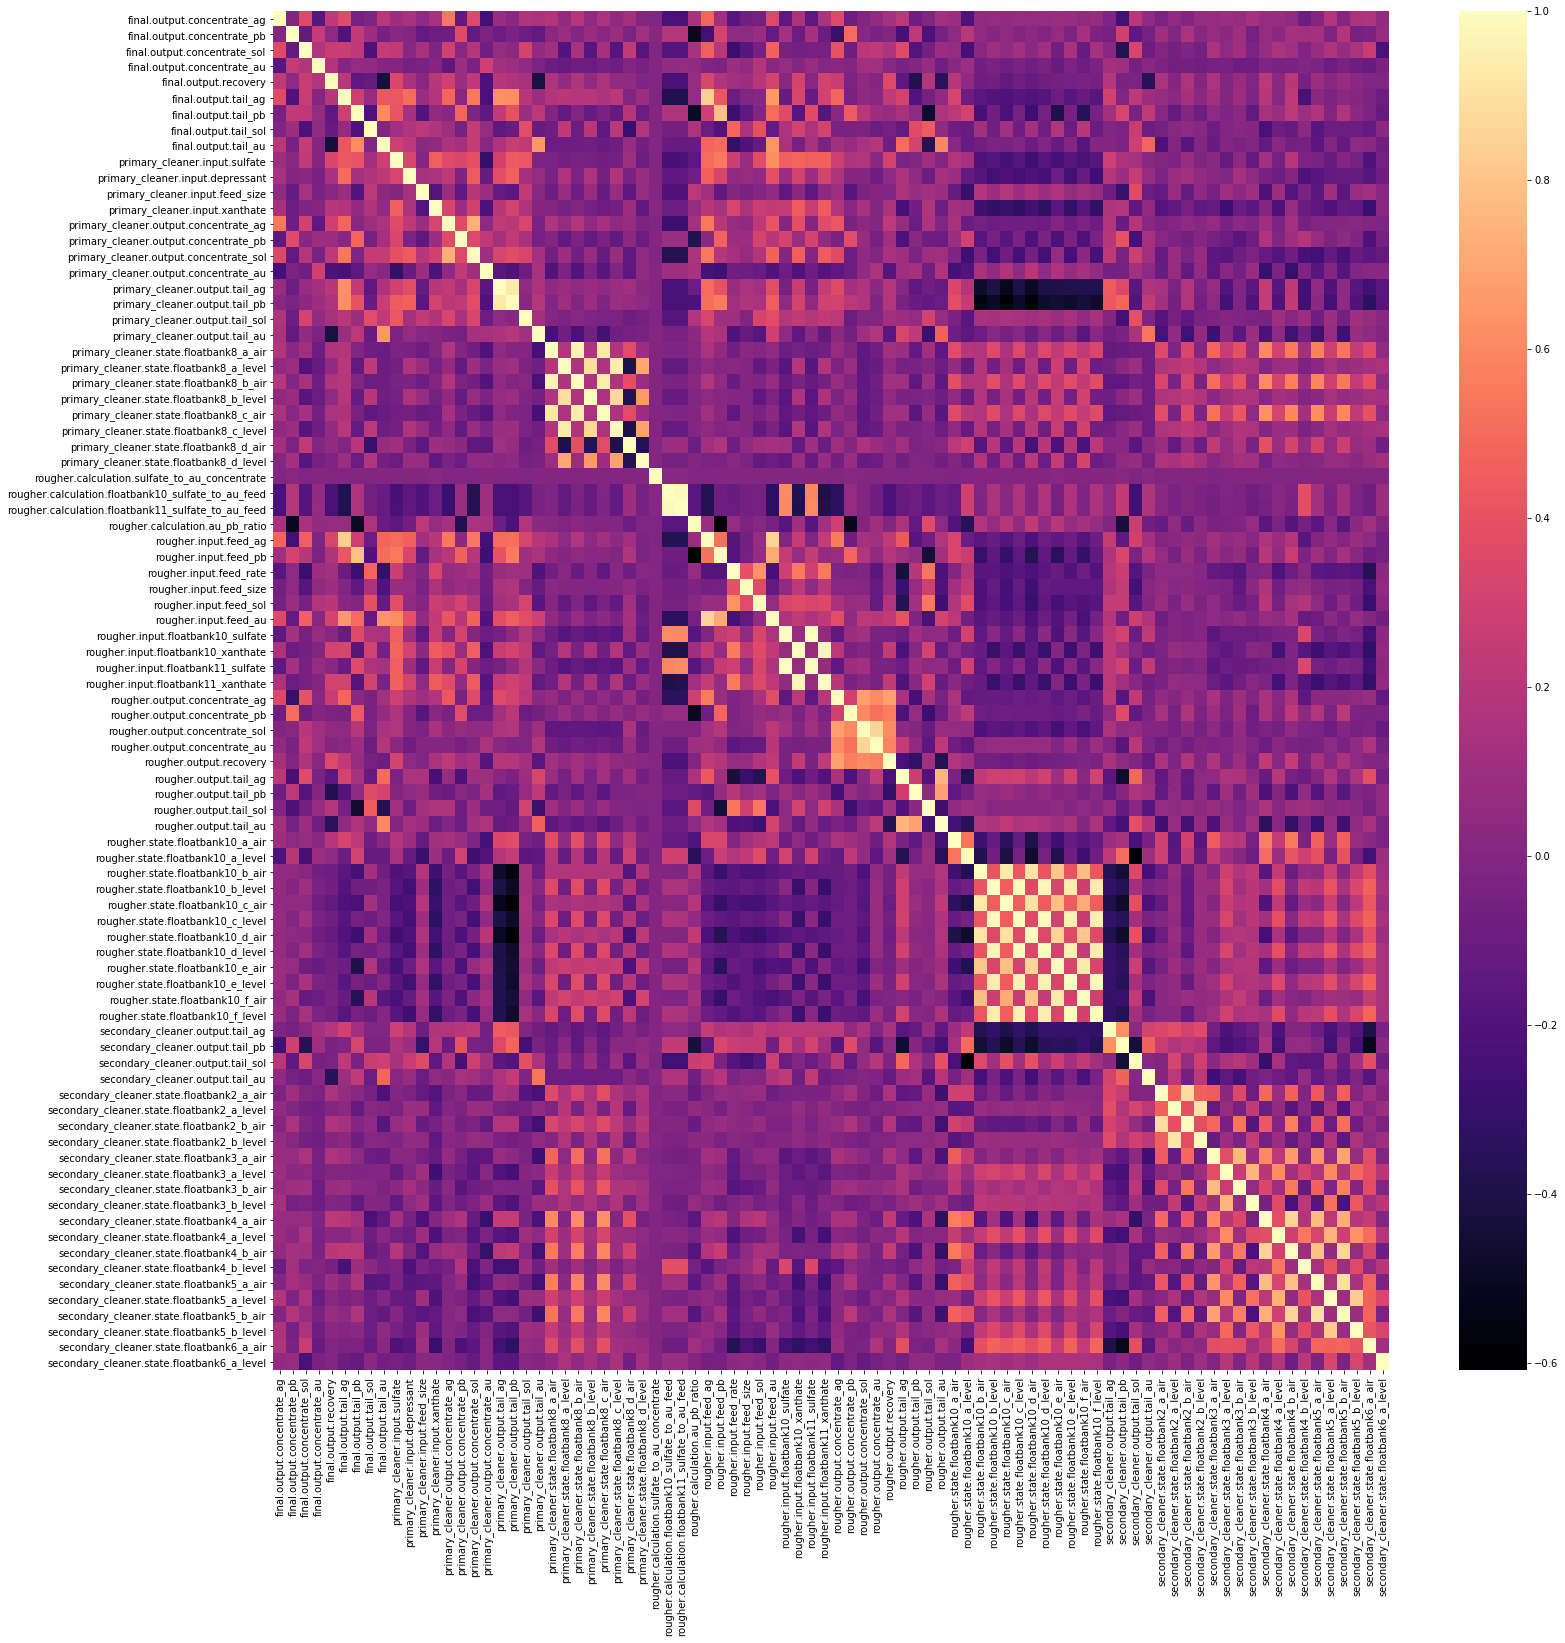

In [268]:
plt.figure(figsize=(25,25))
sns.heatmap(df.corr(),cmap='magma')

На тепловой диаграмме мы видим, что:
- Наибольшая корреляция выявляется у признаков, связанными с флотационными установками (floatbank);
- Выходной продукт и входные ресурсы имеют слабую корреляцию с другими признаками. Скорее всего они связаны не напрямую.

Посмотрим, как меняется концентрация металлов на разных этапах обработки.\
Для этого мы построим графики концентрации металлов (ag, pb, au) на разных стадиях обработки.

In [311]:
#создадим дубликат нашего полного датасэта
data = df
elements = {'ag', 'pb', 'au'}  

# Столбцы с концентратами
metall_concentrate = [col for col in df.columns if any(f'concentrate_{e}' in col for e in elements)]
metall_concentrate

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_au',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_au']

In [312]:
# Разделили столбцы по металлам
au, ag, pb = [list(filter(lambda col: e in col, metall_concentrate))[::-1] for e in elements]

In [313]:
# Выделили этапы, в которых получаются концентраты
stages = sorted(list(set([col[:col.index('.')] for col in metall_concentrate])), reverse=True)
stages

['rougher', 'primary_cleaner', 'final']

In [314]:
metall_conc_df = pd.DataFrame(zip(au, ag, pb), index=stages, columns=elements).applymap(lambda x: data[x].mean())
metall_conc_df

,pb,au,ag
rougher,7.553095,20.052152,12.084945
primary_cleaner,9.884018,32.065559,8.674853
final,9.997593,44.307437,5.190976


([<matplotlib.axis.XTick at 0x7ffa1d684d90>,
 <a list of 3 Text xticklabel objects>)

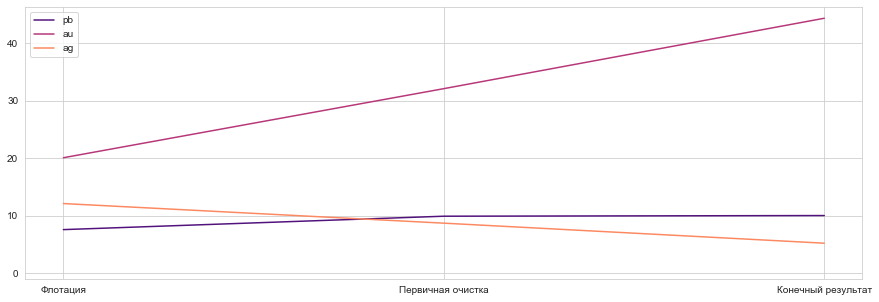

In [315]:
sns.set_style('whitegrid')
plt.figure(figsize=(15,5))
sns.lineplot(data=metall_conc_df, sort=False,dashes=False, palette='magma')
plt.ylim(-1)
plt.xticks(metall_conc_df.index, labels=['Флотация', 'Первичная очистка', 'Конечный результат'])

Из вышеприведенного графика видно, что концентрация золота (au) перманентно увеличивается. 
Что касается остальных металлов - серебра (ag) и свинца (pb), то\
Концентрация серебра (ag) на конечном этапе ниже, чем на этапе флотации;
А концентрация свинца (pb) слегка увеличивается к концу очистки. 

Построим гистограммы частот металлов (au, ag, pb) на разных стадиях очистки

rougher.output.concentrate pb


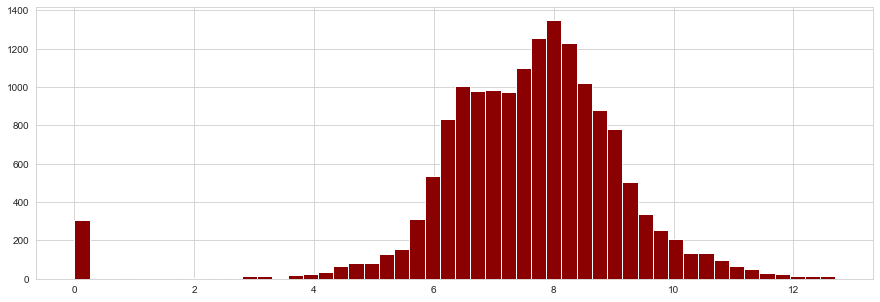

primary_cleaner.output.concentrate pb


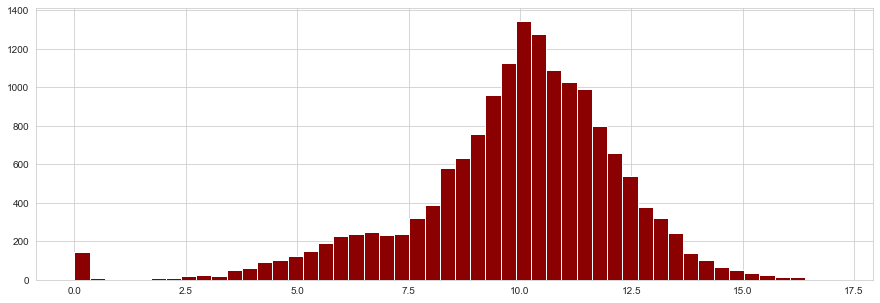

final.output.concentrate pb


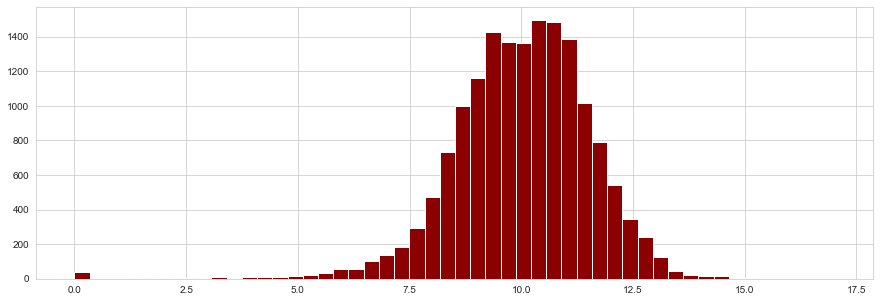

rougher.output.concentrate au


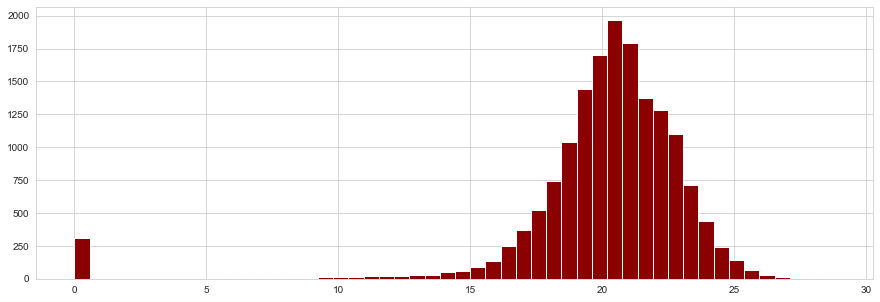

primary_cleaner.output.concentrate au


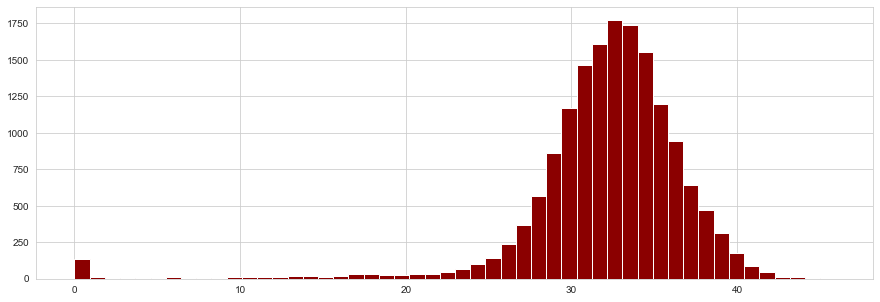

final.output.concentrate au


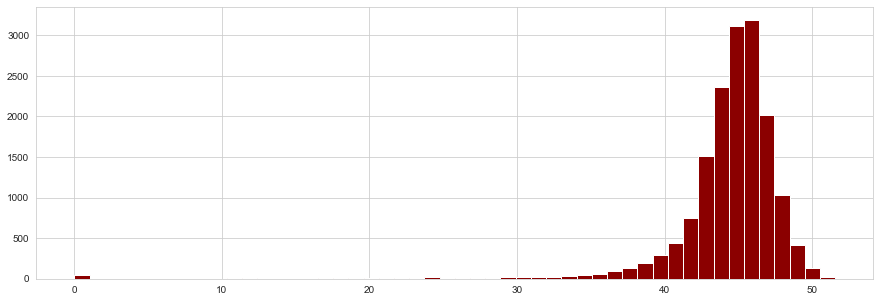

rougher.output.concentrate ag


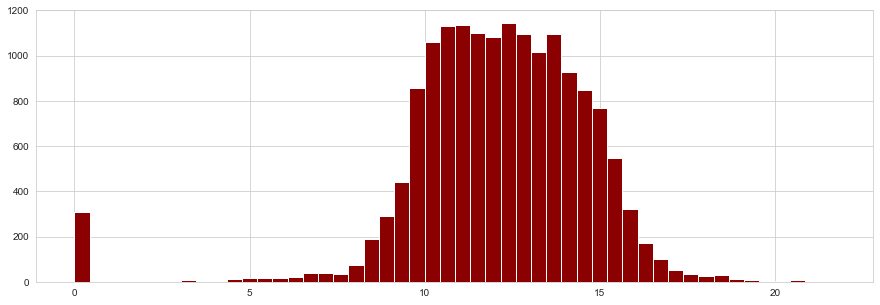

primary_cleaner.output.concentrate ag


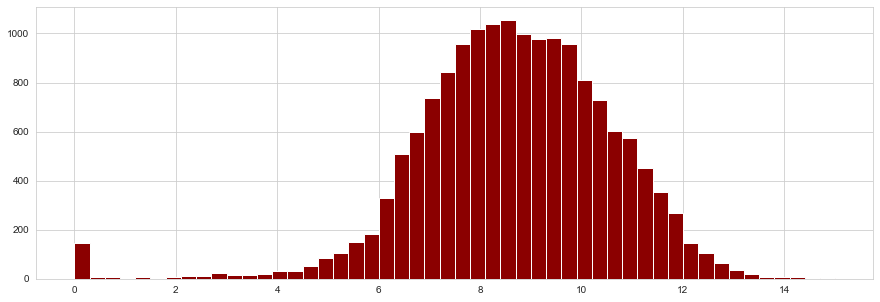

final.output.concentrate ag


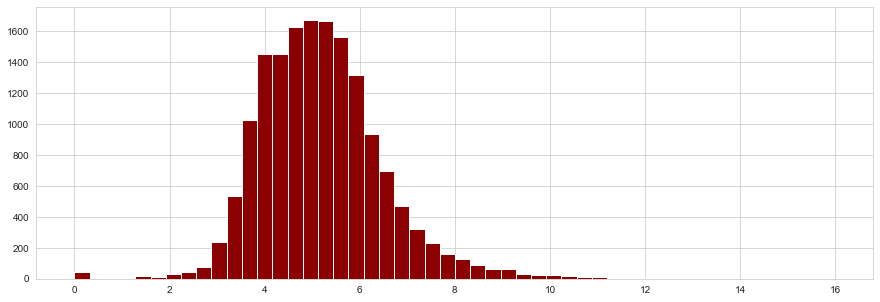

In [316]:
elements = {'ag', 'pb', 'au'}  
stages = {1:'rougher.output.concentrate', 2:'primary_cleaner.output.concentrate', 3:'final.output.concentrate'}

for e in elements:
    for i,st in stages.items():
        plt.figure(figsize=(15,5))
        print(st + ' ' + e) 
        df[st + '_' + e].hist( bins=50, color='darkred')  
        plt.show() 

In [317]:
df.drop(df[df[st + '_' + e] == 0].index , inplace=True) 
df_train.drop(df_train[df_train[st + '_' + e] == 0].index , inplace=True)

Распределение гранул сырья (df_train)


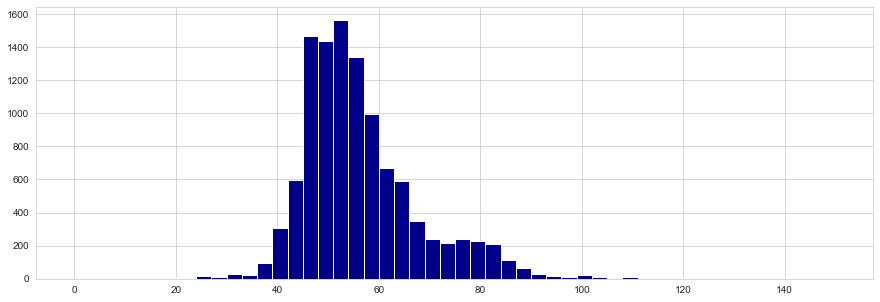

Распределение гранул сырья (df_test)


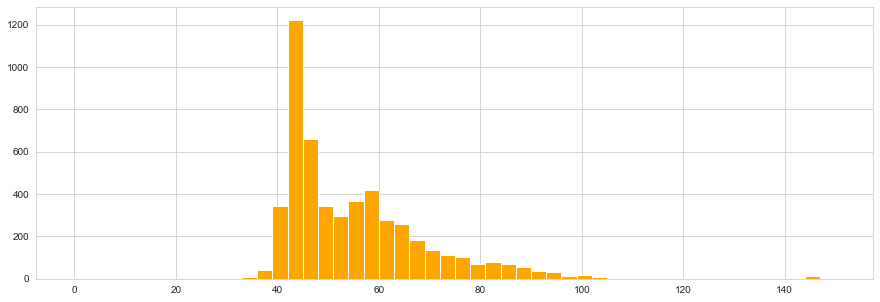

Text(0.5, 1.0, 'Распределение гранул сырья train VS test')

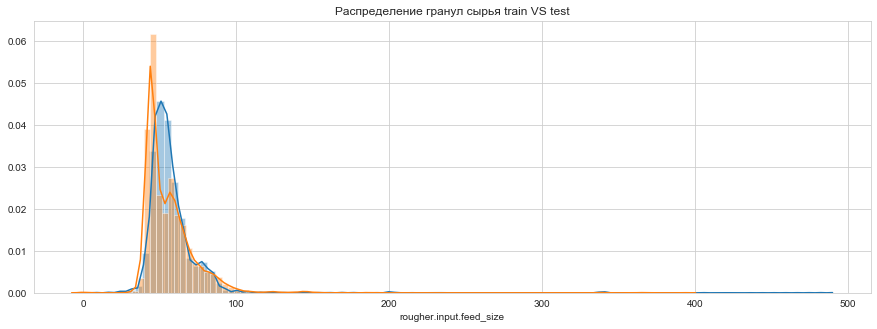

In [318]:
plt.figure(figsize=(15,5))
print("Распределение гранул сырья (df_train)")        
df_train['rougher.input.feed_size'].hist( bins=50, range=(0, 150), color='darkblue' )  
plt.show()  
plt.figure(figsize=(15,5))
print("Распределение гранул сырья (df_test)")        
df_test['rougher.input.feed_size'].hist( bins=50, range=(0, 150), color='orange' )
plt.show() 
plt.figure(figsize=(15,5))
sns.distplot(df_train['rougher.input.feed_size'], label='Обучающая выборка', bins=100)
sns.distplot(df_test['rougher.input.feed_size'], label='Тестовая выборка', bins=100)
plt.title('Распределение гранул сырья train VS test')

Посмотрим на распределение суммарной концентрации металлов на различных этапах очистки.

Суммарное концентрация металлов (Au, Ag, Pb) на различных этапах очистки
TOTAL (Au, Ag, Pb) rougher.output.concentrate


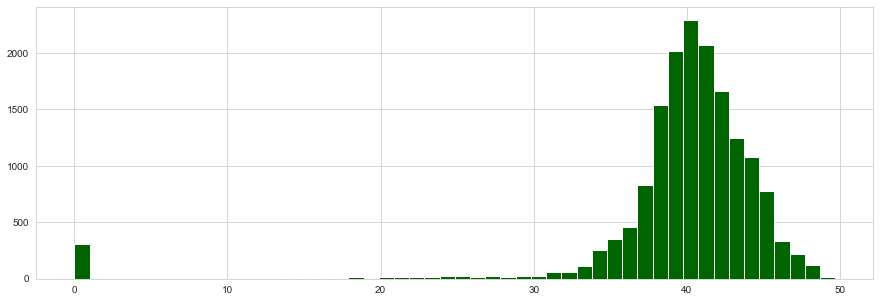

TOTAL (Au, Ag, Pb) primary_cleaner.output.concentrate


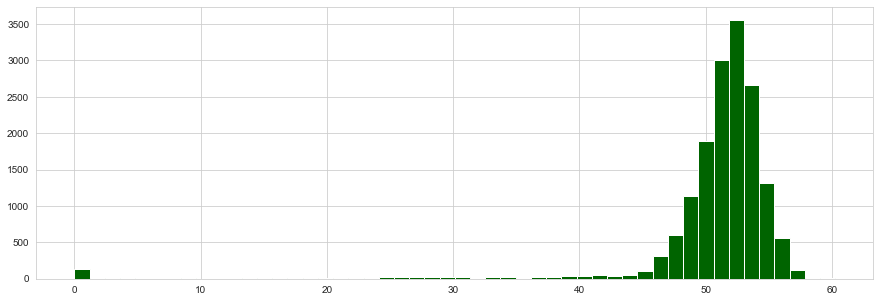

TOTAL (Au, Ag, Pb) final.output.concentrate


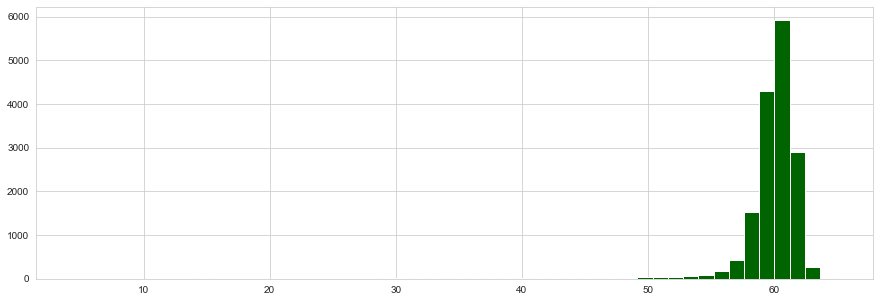

In [319]:
print("Суммарное концентрация металлов (Au, Ag, Pb) на различных этапах очистки") 
for i,st in stages.items():
    plt.figure(figsize=(15,5))
    print('TOTAL (Au, Ag, Pb) ' + st) 
    (df[st + '_au']+df[st + '_ag']+df[st + '_pb']).hist( bins=50 , color='darkgreen')  
    plt.show() 

Концентрация серебра падает с 10%-15% на выходе флотационной установки до 6%-12% на выходе первичного очистителя и 4%-6% после вторичного.
Концентрация золота растёт с ~20% на выходе флотационной установки до ~33% на выходе первичного очистителя и ~46% после вторичного - как и положено установке по добыче золота из руды.
Концентрация свинца практически постоянна на всех этапах: ~8% на выходе флотационной установки, до 10% на выходе первичного очистителя и 10% после вторичного.
Концентрация золи (Sol) падает с ~30% на выходе флотационной установки до 8%-15% на выходе первичного очистителя и ~9% после вторичного.
На всех этапах очистки имеется выброс с нулевой концентрацией хим.элементов - вероятная неполнота данных. Эти данные нельзя использовать при построении модели и исключаются.

Распределение гранул сырья на обучающей и тестовой выборке имеет схожее и не должно сильно повлиять на оценку модели.

Суммарное концентрация металлов (Au, Ag, Pb) на различных этапах очистки растёт с ~40% до ~60%.



# 2.3. Построение модели

In [278]:
df_train = df_train.sample(frac=1, random_state=12345).reset_index(drop=True)
# перемешаем данные для лучших результатов модели

In [279]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

Напишем функцию метрики sMAPE, которую будем использовать в качестве критерия оценки качества модели. 

In [280]:
def sMAPE(prediction, target): 
    return 100*((abs(target - prediction)/((abs(target) + abs(prediction))/2)).mean())

In [281]:
#Выберем модель предсказания эффективности обогащения чернового концентрата

In [282]:
rougher_fX = [col for col in df_train.columns if ('rougher.input' in col or  'rougher.state' in col )]
rougher_X_train = df_train.loc[:,rougher_features]
rougher_X_test = df_test.loc[:,rougher_features]

rougher_y_train = df_train['rougher.output.recovery']
rougher_y_test = df_test['rougher.output.recovery']

In [283]:
results = [] 

linreg = LinearRegression() 
cv = cross_val_score(linreg, rougher_X_train, rougher_y_train, cv=5) 
print('Средняя оценка качества модели линейной регрессии:', cv.mean())

for md in range(20, 35, 15):
    for e in range(20, 70, 30):
        model = RandomForestRegressor(n_estimators=e, max_depth=md, random_state=12345) 
        cv = cross_val_score(model, rougher_X_train, rougher_y_train, cv=5) 
        print('est=',e,'mdepth=',md,' Средняя оценка качества модели случайного леса:', cv.mean())
        results.append([e, md, cv.mean()])

best_model = pd.DataFrame(results, columns = ['estimators', 'depth', 'r2_score'])

print("Лучшая модель по R2-метрике c кроссвалидацией:")
print(best_model.sort_values(by='r2_score', ascending=False).head(1)) 

Средняя оценка качества модели линейной регрессии: 0.19807143673283512
est= 20 mdepth= 20  Средняя оценка качества модели случайного леса: 0.5015391379653619
est= 50 mdepth= 20  Средняя оценка качества модели случайного леса: 0.5119116809079177
Лучшая модель по R2-метрике c кроссвалидацией:
   estimators  depth  r2_score
1          50     20  0.511912


In [284]:
model = RandomForestRegressor(n_estimators=best_model.loc[0].at['estimators'].astype('int'), max_depth=best_model.loc[0].at['depth'].astype('int'), random_state=12345) 
model.fit(rougher_X_train, rougher_y_train) 

predictions_train = model.predict(rougher_X_train) 
sMAPE_rougher_train = sMAPE(predictions_train, rougher_y_train)
print('sMAPE_rougher_train=', sMAPE_rougher_train)

predictions_test = model.predict(rougher_X_test) 
sMAPE_rougher_test = sMAPE(predictions_test, rougher_y_test)
print('sMAPE_rougher_test=', sMAPE_rougher_test)

sMAPE_rougher_train= 4.966030053622623
sMAPE_rougher_test= 15.438260950240052


In [285]:
# Теперь выберем модель предсказания эффективности обогащения финального концентрата

In [286]:
final_features = [col for col in df_test.columns if ('output.' not in col )]
final_X_train = df_train.loc[:,final_features]
final_X_test = df_test.loc[:,final_features]

final_y_train = df_train['final.output.recovery']
final_y_test = df_test['final.output.recovery']

In [287]:
results = []

linreg2 = LinearRegression( ) 
cv = cross_val_score(linreg2, final_X_train, final_y_train, cv=5) 
print('Средняя оценка качества модели линейной регрессии:', cv.mean())

for md in range(20, 35, 15):
    for e in range(20, 70, 30):
        model = RandomForestRegressor(n_estimators=e, max_depth=md, random_state=12345) 
        cv = cross_val_score(model, final_X_train, final_y_train, cv=5) 
        print('est=',e,'mdepth=',md,' Средняя оценка качества RandomForestRegressor-модели:', cv.mean()) 
        results.append([e, md, cv.mean()])

best_model = pd.DataFrame(results, columns = ['estimators', 'depth', 'r2_score'])

print("Лучшая модель по R2-метрике c кроссвалидацией:")
print(best_model.sort_values(by='r2_score', ascending=False).head(1)) 

Средняя оценка качества модели линейной регрессии: 0.3753343800370554
est= 20 mdepth= 20  Средняя оценка качества RandomForestRegressor-модели: 0.6135474387886978
est= 50 mdepth= 20  Средняя оценка качества RandomForestRegressor-модели: 0.6280382083956775
Лучшая модель по R2-метрике c кроссвалидацией:
   estimators  depth  r2_score
1          50     20  0.628038


In [288]:
model = RandomForestRegressor(n_estimators=best_model.loc[0].at['estimators'].astype('int'), max_depth=best_model.loc[0].at['depth'].astype('int'), random_state=12345) 
model.fit(final_X_train, final_y_train) 

predictions_train = model.predict(final_X_train) 
sMAPE_final_train = sMAPE(predictions_train, final_y_train)
print('sMAPE_final_train=', sMAPE_final_train)   

predictions_test = model.predict(final_X_test) 
sMAPE_final_test = sMAPE(predictions_test, final_y_test)
print('sMAPE_final_test=', sMAPE_final_test)

print('sMAPE_total_train=', 0.25*sMAPE_rougher_train + 0.75*sMAPE_final_train) 
print('sMAPE_total_test=', 0.25*sMAPE_rougher_test + 0.75*sMAPE_final_test) 

sMAPE_final_train= 2.429059495394259
sMAPE_final_test= 9.597600471118664
sMAPE_total_train= 3.06330213495135
sMAPE_total_test= 11.057765590899011


На основе кросс-валидации выбраны и построены модели пресказания эффективности обогащения чернового и финального концентратов, получены значения симметричного среднего абсолютного процентного отклонения (sMAPE) для обучающего и тестового наборов данных:\
sMAPE_total_train= 3.06330213495135\
sMAPE_total_test= 11.057765590899011